This notebook will be used to create functions that will show the daily veocity plots with data that ahs been calculated every 15 minutes at the VENUS nodes.

#Plotting the Data

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
import netCDF4 as nc
from dateutil import tz
import os
from glob import glob

from salishsea_tools import(viz_tools, tidetools, nc_tools)
from salishsea_tools.nowcast import (analyze, figures)
from IPython.display import Image
import datetime

%matplotlib inline

In [9]:
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '15', 'color': 'white',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '13', 'color' : 'white'}

In [10]:
def axis_colors(ax, plot):
    """Formats the background colour of plots and colours of labels.

    :arg ax: Axis to be formatted.
    :type ax: axis object

    :arg plot: Keyword for background needed for plot.
    :type plot: string

    :returns: axis format
    """

    labels_c = 'white'
    ticks_c = 'white'
    spines_c = 'white'

    if plot == 'blue':
        ax.set_axis_bgcolor('#2B3E50')
    if plot == 'gray':
        ax.set_axis_bgcolor('#DBDEE1')
    if plot == 'white':
        ax.set_axis_bgcolor('white')

    ax.xaxis.label.set_color(labels_c), ax.yaxis.label.set_color(labels_c)
    ax.tick_params(axis='x', colors=ticks_c)
    ax.tick_params(axis='y', colors=ticks_c)
    ax.spines['bottom'].set_color(spines_c)
    ax.spines['top'].set_color(spines_c)
    ax.spines['left'].set_color(spines_c)
    ax.spines['right'].set_color(spines_c)
    ax.title.set_color('white')

    return ax

In [11]:
def results_dataset_gridded( station, results_dir):
    """Return the results dataset for station (e.g. central or east)
     for the quarter hourly data from results_dir.
    """
        
    filename_pattern = 'VENUS_{station}_gridded.nc'
    filepaths = glob(os.path.join(results_dir, filename_pattern.format(station=station)))
    return nc.Dataset(filepaths[0])


In [12]:
run_date=datetime.date(2015, 5, 12)

# Results dataset location
results_home = '/data/dlatorne/MEOPAR/SalishSea/nowcast/'
results_dir = os.path.join(results_home, run_date.strftime('%d%b%y').lower())


In [13]:
grid_c=results_dataset_gridded('central',results_dir)
grid_e=results_dataset_gridded('east',results_dir)

In [14]:
def unstag_rot_15m(ugrid, vgrid, station):
    """Interpolate u and v component values to values at grid cell centre. Then rotates the 
    grid cells to align with N/E orientation.

    :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`

    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray` 
    
    :arg station: Name of the station ('East' or 'Central')
    :type station: string    

    :returns u_E, v_N, depths: u_E and v_N velocties is the North and East directions at the cell center, 
    and the depth of the station
    """

    if station=='Central':
        depths=330
    else:
        depths=170

    #We need to access the u velocity that is between i and i-1
    u_t=(ugrid[:, :, 1, 0]+ugrid[:, :, 1, 1])/2
    v_t=(vgrid[:, :, 1, 1]+vgrid[:, :, 0, 1])/2
    theta=29 
    theta_rad=theta * np.pi /180

    u_E=u_t * np.cos(theta_rad) - v_t * np.sin(theta_rad)
    v_N=u_t * np.sin(theta_rad) + v_t * np.cos(theta_rad)
    return u_E, v_N, depths

In [24]:
def plot_vel_NE_15m(station, grid, figsize=(16,16)):
    """Plots the hourly averaged North/South and East/West velocities at a chosen 
    VENUS node station using data that is calculated every 15 minutes.
    
    :arg station: Name of the station ('East' or 'Central')
    :type station: string

    :arg grid_U_h: Hourly zonal velocity results dataset from NEMO.
    :type grid_U_h: :class:`netCDF4.Dataset`

    :arg grid_V_h: Hourly meridional velocity results dataset from NEMO.
    :type grid_V_h: :class:`netCDF4.Dataset`
    
    :arg grid_W_h: Hourly vertical velocity results dataset from NEMO.
    :type grid_W_h: :class:`netCDF4.Dataset`  

    :arg figsize: Figure size (width, height) in inches or 'default'.
    :type figsize: 2-tuple

    :returns: matplotlib figure object instance (fig).
    """
    
    u_u= grid.variables['vozocrtx']
    v_v= grid.variables['vomecrty']
    w_w= grid.variables['vovecrtz']
    dep_t= grid.variables['depthv']
    dep_w= grid.variables['depthw']

    u_E, v_N, dep_s=unstag_rot_15m(u_u, v_v,station)

    fig, (axu, axv, axw)=plt.subplots(3,1,figsize=figsize)
    fig.patch.set_facecolor('#2B3E50')
    
    vmax=0.65
    vmin=-vmax
    step=0.005

    #viz_tools.set_aspect(axu)
    timestamp=nc_tools.timestamp(grid,0)
    cmap=plt.get_cmap('jet')
    
    axu.invert_yaxis()
    mesh=axu.contourf(np.arange(0,24,0.25),dep_t[:], u_E.transpose(), np.arange(vmin, vmax, step),cmap=cmap)
    cbar=fig.colorbar(mesh,ax=axu)
    axu.set_ylim([dep_s,0])
    axu.set_xlim([0, 23])
    axu.set_xlabel('Time [h]', **axis_font)
    axu.set_ylabel('Depth [m]', **axis_font)
    axis_colors(axu, 'white')
    axu.set_title('East/West Velocities at VENUS {node} on {date}'.format(node=station, date=timestamp.format('DD-MMM-YYYY')), **title_font) 
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
    cbar.set_label('[m/s]', **axis_font)


    axv.invert_yaxis()
    mesh=axv.contourf(np.arange(0,24,0.25),dep_t[:], v_N.transpose(), np.arange(vmin, vmax, step),cmap=cmap)
    cbar=fig.colorbar(mesh,ax=axv)
    axv.set_ylim([dep_s,0])
    axv.set_xlim([0,23])
    axv.set_xlabel('Time [h]', **axis_font)
    axv.set_ylabel('Depth [m]', **axis_font)
    axis_colors(axv, 'white')
    axv.set_title('North/South Velocities at VENUS {node} on {date}'.format(node=station, date=timestamp.format('DD-MMM-YYYY')), **title_font) 
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
    cbar.set_label('[m/s]', **axis_font)
    
    axw.invert_yaxis()
    mesh=axw.contourf(np.arange(0,24,0.25), dep_w[:], w_w[:,:,1,1].transpose(), np.arange(vmin/80, vmax/80, step/80),cmap=cmap)
    cbar=fig.colorbar(mesh,ax=axw)
    axw.set_ylim([dep_s,0])
    axw.set_xlim([0,23])
    axw.set_xlabel('Time [h]',**axis_font)
    axw.set_ylabel('Depth [m]', **axis_font)
    axis_colors(axw, 'white')
    axw.set_title('Vertical Velocities at VENUS {node} on {date}'.format(node=station, date=timestamp.format('DD-MMM-YYYY')), **title_font) 
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='w')
    cbar.set_label('[m/s]', **axis_font)

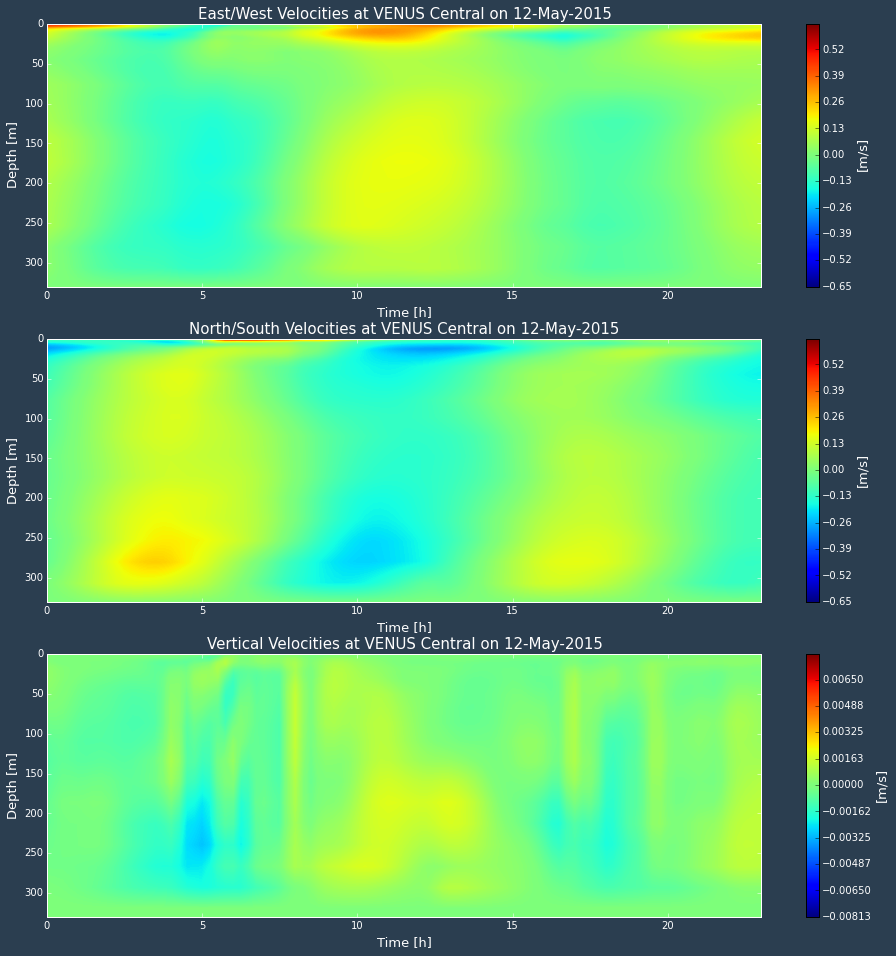

In [25]:
plot_vel_NE_15m('Central', grid_c)

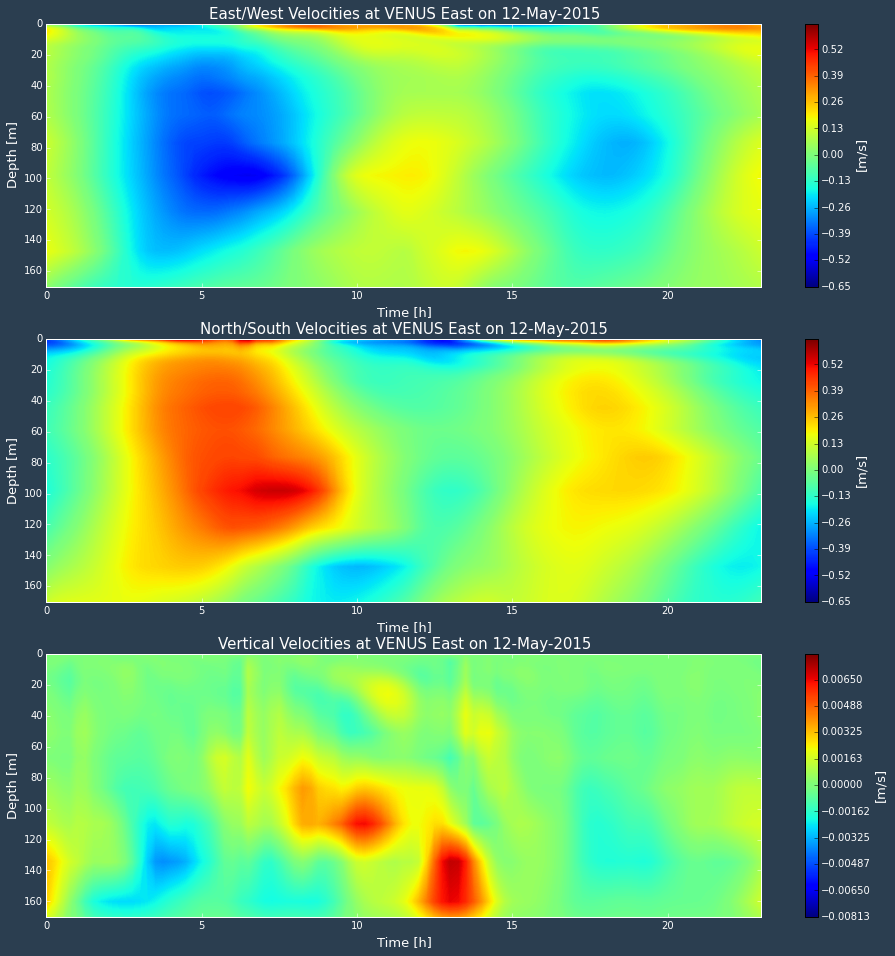

In [26]:
plot_vel_NE_15m('East', grid_e)